# Credit Card Managment System

Companies like Amex have millions of customers with multiple credit cards. They need to store all the customer information in a well structured database while maintaining low redundancy in the data. Furthermore, they have to manage and process the transactions for each of the customers ensuring that there are no mistakes. How do they do this? How do they manage all the data of their customers. In this project, we aim to develop a credit card management system which emulates that of companies like Amex, Discover, etc.

In [1]:
#import libraries and connect to the database
import ipywidgets as widgets
import mysql.connector as msql
from mysql.connector import Error
from IPython.display import Markdown, display
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
mysql_hst = 'localhost'
mysql_usr = 'root'
mysql_pwd = 'YOUR PASSWORD'

<b>Our database has the following tables:</b>

In [2]:
try:
    conn = msql.connect(
                        host = mysql_hst, 
                        user = mysql_usr, 
                        password = mysql_pwd
                        ) #Give MySQL localhost username, password
    
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("use ccms;")
        cursor.execute("show full tables where Table_Type != 'VIEW';")
        tables=cursor.fetchall()
        tables=[i[0] for i in tables]
        data=[]
        for i in tables:
            query=f"SELECT COUNT(*) from {i};"
            cursor.execute(query)
            data.append([i,cursor.fetchone()[0]])
except Error as e:
    print("Error while connecting to MySQL: ", e)

conn.close()    
display(Markdown(pd.DataFrame(data=data,columns=['Table','No. of rows']).to_markdown()))

|    | Table                |   No. of rows |
|---:|:---------------------|--------------:|
|  0 | card                 |          1500 |
|  1 | card_limit           |          1500 |
|  2 | card_statement       |          5917 |
|  3 | card_type            |            10 |
|  4 | customer             |          1000 |
|  5 | merchant             |            32 |
|  6 | merchant_type        |            13 |
|  7 | netbanking           |          1000 |
|  8 | notification         |        287552 |
|  9 | rewards              |        287552 |
| 10 | transaction          |        287552 |
| 11 | transaction_terminal |           100 |
| 12 | transaction_type     |             4 |

### Let's explore the data

Using the data in our database. We can answer many interesting questions like:

1. Who are the top 5 merchants?
2. Who are the highest transacting customers?
3. Which are the cities where the most money is spent?
4. What is the number of active users in given date range?
5. Is there any trend for transactions and transaction amount for the given time period?

### 1. Who are the top 5 merchants?

In [3]:
try:
    conn = msql.connect(
                    host = 'localhost', 
                    user = mysql_usr, 
                    password = mysql_pwd,
                    database='ccms'
                    ) #Give MySQL localhost username, password  
    query='SELECT * FROM merchant_transactions where rank_by_txn_amt<=5;'
    result=pd.read_sql_query(query,conn)
    result.drop(columns=['rank_by_num_txn','rank_by_txn_amt'],inplace=True)
    display(Markdown(result.to_markdown()))
    conn.close() #close the connection              
except Error as e:
    print('We are encountering the following error:', e)

|    | merchant_type             | merchant                 |   num_transactions |   total_txn_amt |
|---:|:--------------------------|:-------------------------|-------------------:|----------------:|
|  0 | drug store/pharmacy       | Walgreens Boots Alliance |              20412 |     1.07731e+06 |
|  1 | supermarket               | Publix                   |              20387 |     1.07528e+06 |
|  2 | discount department store | Target Corporation       |              20306 |     1.07345e+06 |
|  3 | non-store,e-commerce      | Amazon                   |              20439 |     1.07127e+06 |
|  4 | electronics specialty     | Best Buy                 |              20405 |     1.06939e+06 |

### 2. Who are the highest transacting customers?

In [4]:
try:
    conn = msql.connect(
                    host = 'localhost', 
                    user = mysql_usr, 
                    password = mysql_pwd,
                    database='ccms'
                    ) #Give MySQL localhost username, password  
    query='SELECT * FROM customer_transactions where rank_by_txn_amt<=5;'
    result=pd.read_sql_query(query,conn)
    result.drop(columns=['rank_by_num_txn','rank_by_txn_amt'],inplace=True)
    display(Markdown(result.to_markdown()))
    conn.close() #close the connection              
except Error as e:
    print('We are encountering the following error:', e)

|    | first_name   | last_name   | email                         |   num_transactions |   total_txn_amt |
|---:|:-------------|:------------|:------------------------------|-------------------:|----------------:|
|  0 | Christina    | Reyes       | christinareyes158@gmail.com   |                896 |         85936.3 |
|  1 | Jennifer     | Mccarthy    | jennifermccarthy345@yahoo.com |                878 |         71977.1 |
|  2 | Cynthia      | Alexander   | cynthiaalexander409@gmail.com |                829 |         68113.1 |
|  3 | Wanda        | Conrad      | wandaconrad885@yahoo.com      |                909 |         63805.2 |
|  4 | Steven       | Meyer       | stevenmeyer498@gmail.com      |                750 |         62292.8 |

### 3. Which are the cities where the most money is spent?

In [5]:
try:
    conn = msql.connect(
                    host = 'localhost', 
                    user = mysql_usr, 
                    password = mysql_pwd,
                    database='ccms'
                    ) #Give MySQL localhost username, password  
    query='SELECT * FROM city_transactions where rank_by_txn_amt<=5;'
    result=pd.read_sql_query(query,conn)
    result.drop(columns=['rank_by_num_txn','rank_by_txn_amt'],inplace=True)
    display(Markdown(result.to_markdown()))
    conn.close() #close the connection              
except Error as e:
    print('We are encountering the following error:', e)

|    | city         |   num_transactions |    total_txn_amt |
|---:|:-------------|-------------------:|-----------------:|
|  0 | Arvada       |              20468 |      1.06934e+06 |
|  1 | Anchorage    |              15193 | 836460           |
|  2 | Nashville    |              15156 | 789842           |
|  3 | Fayetteville |              14410 | 784847           |
|  4 | Glendale     |              12454 | 757735           |

### 4. What is the number of active users in given date range?

Data is available for the months from June-September.

In [93]:
start=widgets.DatePicker(
    value=datetime.datetime(2022,7,1),
    description='Startdate',
    disabled=False)
end=widgets.DatePicker(
    value=datetime.datetime(2022,7,31),
    description='End date',
    disabled=False)
dbutton=widgets.Button(
    description='Execute',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check')
outd=widgets.Output()

In [94]:
def select_date(change):
    outd.clear_output()
    # logic for crud query
    try:
        conn = msql.connect(
                        host = 'localhost', 
                        user = mysql_usr, 
                        password = mysql_pwd,
                        database='ccms'
                        ) #Give MySQL localhost username, password
        start_str=start.value.strftime("%Y-%m-%d")
        end_str=end.value.strftime("%Y-%m-%d")
        query=f'select get_active_customers_for_range("{start_str}", "{end_str}") as active_customers;'
        result=pd.read_sql_query(query,conn)
        with outd:
            display(Markdown(result.head(100).to_markdown()))
        conn.close() #close the connection              
    except Error as e:
        outd.clear_output()
        with outd:
            print('We are encountering the following error:', e)
                    
dbutton.on_click(select_date)

In [95]:
widgets.VBox([
    start,
    end,
    dbutton,
    outd])

### 5. Is there any trend for transactions and transaction amount  for the given time period?

In [20]:
try:
    conn = msql.connect(
                    host = 'localhost', 
                    user = mysql_usr, 
                    password = mysql_pwd,
                    database='ccms'
                    ) #Give MySQL localhost username, password  
    query='SELECT * FROM transactions_time_series'
    result=pd.read_sql_query(query,conn)
    result.drop(columns=['rank_by_num_txn','rank_by_txn_amt'],inplace=True)
    conn.close() #close the connection              
except Error as e:
    print('We are encountering the following error:', e)

Plot for date vs total amount of transactions per day

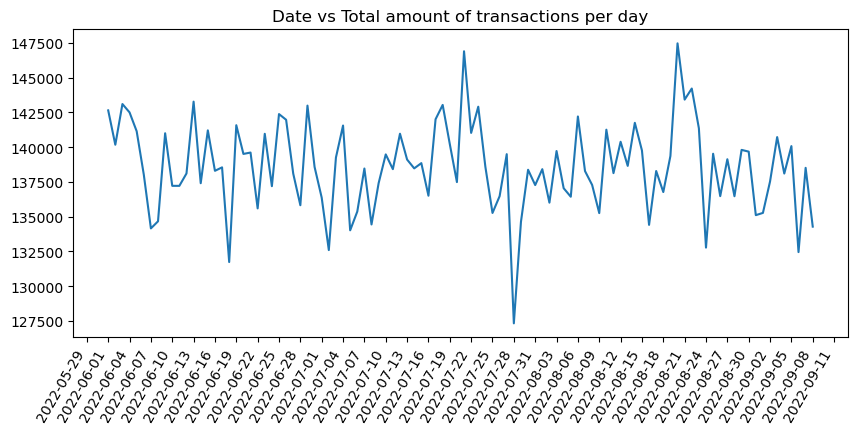

In [21]:
fig=plt.figure()
fig.set_size_inches(10,4)
plt.plot(result['txn_date'],result['total_txn_amt'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) 
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right") 
plt.title(f"Date vs Total amount of transactions per day")
plt.show()

Plot for date vs number of transactions

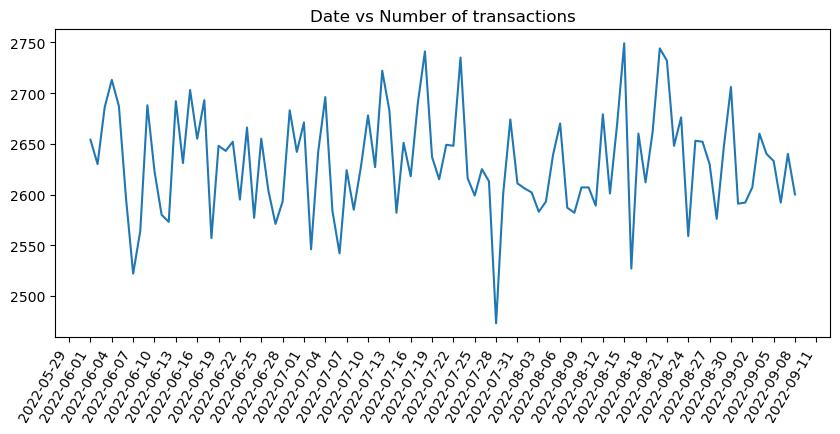

In [22]:
fig=plt.figure()
fig.set_size_inches(10,4)
plt.plot(result['txn_date'],result['num_transactions'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) 
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right") 
plt.title(f"Date vs Number of transactions")
plt.show()

### INSERT, UPDATE or DELETE queries panel
This portion of the application allows you to <b>insert, update or delete records </b> to/from the tables.

In [12]:
# initialize all the widgets
username=widgets.Password(
    value='',
    placeholder='Enter username',
    description='Username:',
    disabled=False
)
password=widgets.Password(
    value='',
    placeholder='Enter password',
    description='Password:',
    disabled=False
)
crud_query=widgets.Textarea(
    value='Enter your query',
    placeholder='Query',
    description='String:',
    disabled=False
)
button = widgets.Button(
    description='Execute',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)
out=widgets.Output()

In [13]:
def crud_ops(change):
    out.clear_output()
    # logic for crud query
    try:
        conn = msql.connect(
                        host = 'localhost', 
                        user = username.value, 
                        password = password.value
                        ) #Give MySQL localhost username, password
        cursor = conn.cursor() #initialize cursor 
        cursor.execute("use ccms;")
        sql = crud_query.value
        cursor.execute(sql)
        conn.commit()
        conn.close() #close the connection 
        if bool(re.search('^INSERT',sql,re.IGNORECASE)):
            with out:
                print('Successfully inserted row!!')
        elif bool(re.search('^UPDATE',sql,re.IGNORECASE)):
            with out:
                print('Successfully updated row!!')
        elif bool(re.search('^DELETE',sql,re.IGNORECASE)):
            with out:
                print('Successfully deleted row!!')               
    except Error as e:
        out.clear_output()
        with out:
            print('We are encountering the following error:', e)
                    
button.on_click(crud_ops)

In [14]:
widgets.VBox([username, 
      password,
      crud_query,
      button,
      out])

### SELECT queries panel
You can also enter select queries here and get the desired data from the database.

In [15]:
# initialize all the widgets
username2=widgets.Password(
    value='',
    placeholder='Enter username',
    description='Username:',
    disabled=False
)
password2=widgets.Password(
    value='',
    placeholder='Enter password',
    description='Password:',
    disabled=False
)
select_query=widgets.Textarea(
    value='Enter your query',
    placeholder='Query',
    description='String:',
    disabled=False
)
button2 = widgets.Button(
    description='Execute',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)
out2=widgets.Output()

In [16]:
def select_ops(change):
    out2.clear_output()
    # logic for crud query
    try:
        conn = msql.connect(
                        host = 'localhost', 
                        user = username2.value, 
                        password = password2.value,
                        database='ccms'
                        ) #Give MySQL localhost username, password  
        result=pd.read_sql_query(select_query.value,conn)
        with out2:
            display(Markdown(result.head(100).to_markdown()))
        conn.close() #close the connection              
    except Error as e:
        out2.clear_output()
        with out2:
            print('We are encountering the following error:', e)
                    
button2.on_click(select_ops)

In [17]:
widgets.VBox([
    username2,
    password2,
    select_query,
    button2,
    out2])